# Path setup & import packages

In [5]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from datasets.imdb_tmdb_dataset import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
seed = 42
feature_drop_cols = ['vote_average', 'imdbId', 'movieId','tmdbId']
label_feature = 'vote_average'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# read data
df = pd.read_csv(os.path.join(root_path, 'data',
                              'imdb-tmdb', 'merged_imdb_tmdb_with_additional_features.csv')).fillna(0)

X, Y = df.drop(feature_drop_cols, axis=1), df[label_feature]

# split data
train_fraction = 0.75
# # split data
indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
X_train = X.iloc[indices_train]
Y_train = Y[indices_train]
X_test = X.iloc[indices_test]
Y_test = Y[indices_test]

# model declaration and fit
model = Pipeline([
    ("std", StandardScaler()),
    ("model", LinearRegression())
])
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
true_mse = mean_squared_error(Y_test, Y_test_pred)
print('MSE', true_mse)

MSE 2.294897251969756e+22


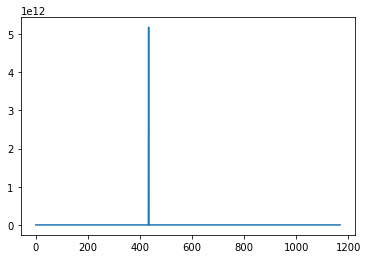

In [14]:
plt.plot(Y_test_pred)

In [15]:
residual = np.abs(model.predict(X_train) - Y_train)
residual

3771    0.060972
1612    0.759433
353     0.170353
4012    0.227177
2689    1.324300
          ...   
4426    0.088707
466     0.664639
3092    0.418851
3772    0.175820
860     0.752871
Name: vote_average, Length: 3507, dtype: float64

In [20]:
df_result = pd.DataFrame()

for seed in range(10):
    for p in [0.001, 0.005, 0.01, 0.05, 0.1, 0.25]:
        sample_percent = p * 100
        q = 1-p
        bad_indices = residual >= residual.quantile(q)
        X_train_bad = X_train[bad_indices]
        Y_train_bad = Y_train[bad_indices]

        # model declaration and fit
        model = Pipeline([
            ("std", StandardScaler()),
            ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed)),
        ])
        model.fit(X_train_bad, Y_train_bad)

        # result visualization
        Y_test_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_test_pred)
        df_result = df_result.append({
            'seed': seed,
            'sample_percent': sample_percent,
            'mse': mse
        }, ignore_index=True
        )

In [21]:
df_result.groupby('sample_percent').agg(['mean', 'std'])['mse']

,mean,std
sample_percent,,
0.1,39.450197,0.000000
0.5,5.694745,0.625304
1.0,6.815121,0.092757
5.0,1.434143,0.009969
10.0,0.855947,0.004779
25.0,0.517484,0.001702


In [22]:
df_result.groupby('sample_percent').agg(['mean', 'std'])['mse'].to_csv('badsubset.csv')